# **Homework 6 - Generative Adversarial Network**

This is the example code of homework 6 of the machine learning course by Prof. Hung-yi Lee.


In this homework, you are required to build a generative adversarial  network for anime face generation.


In [1]:
import torch
try:
    # Get GPU name, check if it's K80
    GPU_name = torch.cuda.get_device_name()
    if GPU_name[-3:] == "K80":
        print("Get K80! :'( RESTART!")
        exit()  # Restart the session
    else:
        print("Your GPU is {}!".format(GPU_name))
        print("Great! Keep going~")
except RuntimeError as e:
    if e.args == ("No CUDA GPUs are available",):
        print("You are training with CPU! "
              "Please restart!")
        exit()  # Restart the session
    else:
        print("What's wrong here?")
        print("Error message: \n", e)

Your GPU is Tesla T4!
Great! Keep going~


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set up the environment


### Packages Installation

In [5]:
# You may replace the workspace directory if you want.
workspace_dir = '.'

# Training progress bar
!pip install -q qqdm

### Download the dataset
**Please use the link according to the last digit of your student ID first!**

If all download links fail, please follow [here](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e).

* To open the file using your browser, use the link below (replace the id first!):
https://drive.google.com/file/d/REPLACE_WITH_ID
* e.g. https://drive.google.com/file/d/1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p

In [6]:
!gdown --id 1R7Jrgo0K20yD_DRJLQxosnKzGDhyLKW3 --output "{workspace_dir}/crypko_data.zip"

# Other download links
#   Please uncomment the line according to the last digit of your student ID first

# 0
# !gdown --id 131zPaVoi-U--XThvzgRfaxrumc3YSBd3 --output "{workspace_dir}/crypko_data.zip"

# 1
# !gdown --id 1kCuIj1Pf3T2O94H9bUBxjPBKb---WOmH --output "{workspace_dir}/crypko_data.zip"

# 2
# !gdown --id 1boEoiiqBJwoHVvjmI0xgoutE9G0Rv8CD --output "{workspace_dir}/crypko_data.zip"

# 3
# !gdown --id 1Ic0mktAQQvnNAnswrPHsg-u2OWGBXTWF --output "{workspace_dir}/crypko_data.zip"

# 4
# !gdown --id 1PFcc25r9tLE7OyQ-CDadtysNdWizk6Yg --output "{workspace_dir}/crypko_data.zip"

# 5
# !gdown --id 1wgkrYkTrhwDSMdWa5NwpXeE4-7JaUuX2 --output "{workspace_dir}/crypko_data.zip"

# 6
# !gdown --id 19gwNYWi9gN9xVL86jC3v8qqNtrXyq5Bf --output "{workspace_dir}/crypko_data.zip"

# 7 
# !gdown --id 1-KPZB6frRSRLRAtQfafKCVA7em0_NrJG --output "{workspace_dir}/crypko_data.zip"

# 8
# !gdown --id 1rNBfmn0YBzXuG5ub7CXbsGwduZqEs8hx --output "{workspace_dir}/crypko_data.zip"

# 9
# !gdown --id 113NEISX-2j6rBd1yyBx0c3_9nPIzSNz- --output "{workspace_dir}/crypko_data.zip"


Downloading...
From: https://drive.google.com/uc?id=1R7Jrgo0K20yD_DRJLQxosnKzGDhyLKW3
To: /content/crypko_data.zip
452MB [00:01, 274MB/s]


###Unzip the downloaded file.
The unzipped tree structure is like 
```
faces/
├── 1.jpg
├── 2.jpg
├── 3.jpg
...
```

In [7]:
!unzip -q "{workspace_dir}/crypko_data.zip" -d "{workspace_dir}/"

## Random seed
Set the random seed to a certain value for reproducibility.

In [8]:
import random

import torch
import numpy as np


def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(2021)

## Import Packages
First, we need to import packages that will be used later.

Like hw3, we highly rely on **torchvision**, a library of PyTorch.

In [9]:
import os
import glob

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from qqdm.notebook import qqdm
from torch.nn.utils import spectral_norm

## Dataset
1. Resize the images to (64, 64)
1. Linearly map the values from [0, 1] to  [-1, 1].

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.


In [10]:
class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        # 1. Load the image
        img = torchvision.io.read_image(fname)
        # 2. Resize and normalize the images using torchvision.
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples


def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    # 1. Resize the image to (64, 64)
    # 2. Linearly map [0, 1] to [-1, 1]
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        # transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset

### Show some images
Note that the values are in the range of [-1, 1], we should shift them to the valid range, [0, 1], to display correctly.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


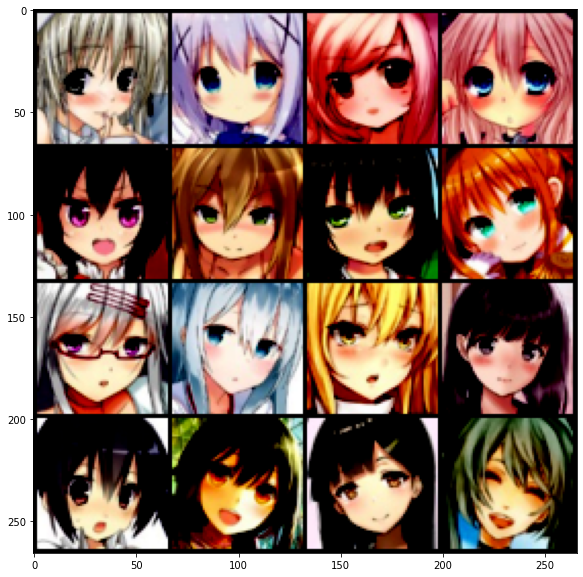

In [11]:
# [-1, 1] Wrong
dataset = get_dataset(os.path.join(workspace_dir, 'faces'))

images = [dataset[i] for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

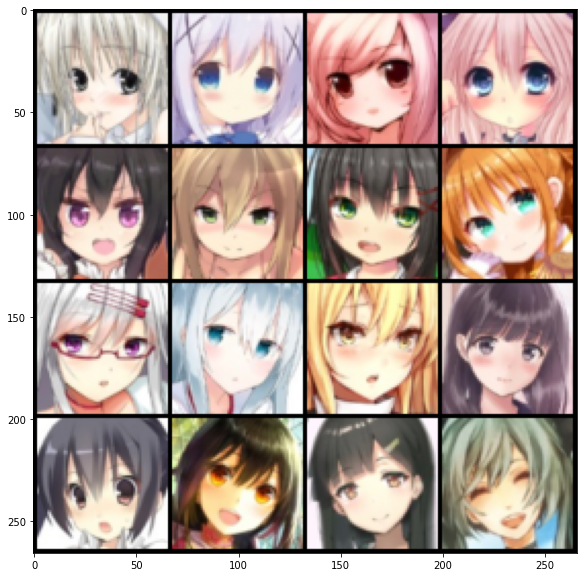

In [12]:
# [0, 1] Correct
images = [(dataset[i]+1)/2 for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## Model
Here, we use DCGAN as the model structure. Feel free to modify your own model structure.

Note that the `N` of the input/output shape stands for the batch size.

In [13]:
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim,activation):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out,attention

class Generator(nn.Module):
    """Generator."""

    def __init__(self, image_size=64, z_dim=100, conv_dim=64):
        super(Generator, self).__init__()
        self.imsize = image_size
        layer1 = []
        layer2 = []
        layer3 = []
        last = []

        repeat_num = int(np.log2(self.imsize)) - 3
        mult = 2 ** repeat_num # 8
        layer1.append(spectral_norm(nn.ConvTranspose2d(z_dim, conv_dim * mult, 4)))
        layer1.append(nn.BatchNorm2d(conv_dim * mult))
        layer1.append(nn.ReLU())

        curr_dim = conv_dim * mult

        layer2.append(spectral_norm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer2.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer2.append(nn.ReLU())

        curr_dim = int(curr_dim / 2)

        layer3.append(spectral_norm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer3.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer3.append(nn.ReLU())

        if self.imsize == 64:
            layer4 = []
            curr_dim = int(curr_dim / 2)
            layer4.append(spectral_norm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
            layer4.append(nn.BatchNorm2d(int(curr_dim / 2)))
            layer4.append(nn.ReLU())
            self.l4 = nn.Sequential(*layer4)
            curr_dim = int(curr_dim / 2)

        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)

        last.append(nn.ConvTranspose2d(curr_dim, 3, 4, 2, 1))
        last.append(nn.Tanh())
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn( 128, 'relu')
        self.attn2 = Self_Attn( 64,  'relu')

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        out=self.l1(z)
        out=self.l2(out)
        out=self.l3(out)
        out,p1 = self.attn1(out)
        out=self.l4(out)
        out,p2 = self.attn2(out)
        out=self.last(out)

        return out


class Discriminator(nn.Module):
    """Discriminator, Auxiliary Classifier."""

    def __init__(self, image_size=64, conv_dim=64):
        super(Discriminator, self).__init__()
        self.imsize = image_size
        layer1 = []
        layer2 = []
        layer3 = []
        last = []

        layer1.append(spectral_norm(nn.Conv2d(3, conv_dim, 4, 2, 1)))
        layer1.append(nn.LeakyReLU(0.1))

        curr_dim = conv_dim

        layer2.append(spectral_norm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer2.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        layer3.append(spectral_norm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer3.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        if self.imsize == 64:
            layer4 = []
            layer4.append(spectral_norm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
            layer4.append(nn.LeakyReLU(0.1))
            self.l4 = nn.Sequential(*layer4)
            curr_dim = curr_dim*2
        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)

        last.append(nn.Conv2d(curr_dim, 1, 4))
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn(256, 'relu')
        self.attn2 = Self_Attn(512, 'relu')

    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out,p1 = self.attn1(out)
        out=self.l4(out)
        out,p2 = self.attn2(out)
        out=self.last(out)

        return out.squeeze()

## Training

### Initialization
- hyperparameters
- model
- optimizer
- dataloader

In [14]:
# Training hyperparameters
batch_size = 64
z_dim = 100 # input的dimension
z_sample = Variable(torch.randn(100, z_dim)).cuda() # 隨機給generator的input(100張)，print出圖片看訓練效果好不好
D_lr = 4 * 1e-4
G_lr = 1e-4

n_epoch = 50 # 50

log_dir = os.path.join(workspace_dir, 'logs')
save_path = './drive/MyDrive/ML大金/HW6'
os.makedirs(log_dir, exist_ok=True)

# Model
G = Generator().cuda()
D = Discriminator().cuda()
G.train()
D.train()

# Loss
criterion = nn.BCELoss()

""" Medium: Use RMSprop for WGAN. """
# Optimizer
opt_D = torch.optim.Adam(D.parameters(), lr=D_lr, betas=(0, 0.9))
opt_G = torch.optim.Adam(G.parameters(), lr=G_lr, betas=(0, 0.9))

# DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


### Training loop
We store some pictures regularly to monitor the current performance of the Generator, and regularly record checkpoints.

In [15]:
steps = 0

load = False
if load:
    G.load_state_dict(torch.load(os.path.join(save_path, 'G_SA.pth')))
    D.load_state_dict(torch.load(os.path.join(save_path, 'D_SA.pth')))
    print('Model loaded from:', save_path)

for epoch in range(n_epoch):
    progress_bar = qqdm(dataloader)
    for i, data in enumerate(progress_bar):
        imgs = data
        imgs = imgs.cuda()

        bs = imgs.size(0)

        # ============================================
        #  Train D (Discriminator)
        # ============================================
        z = Variable(torch.randn(bs, z_dim)).cuda()
        r_imgs = Variable(imgs).cuda()
        f_imgs = G(z)

        d_loss_real = torch.nn.ReLU()(1.0 - D(r_imgs)).mean()
        d_loss_fake = torch.nn.ReLU()(1.0 + D(f_imgs)).mean()
        loss_D = d_loss_real + d_loss_fake

        # Model backwarding
        D.zero_grad()
        loss_D.backward()

        # Update the discriminator.
        opt_D.step()

        # ============================================
        #  Train G (Generator)
        # ============================================
        # Generate some fake images.
        z = Variable(torch.randn(bs, z_dim)).cuda()
        f_imgs = G(z)

        # Model forwarding
        f_logit = D(f_imgs)
        
        # Hinge Loss
        loss_G = -f_logit.mean()

        # Model backwarding
        G.zero_grad()
        loss_G.backward()

        # Update the generator.
        opt_G.step()


        steps += 1
        
        # Set the info of the progress bar
        #   Note that the value of the GAN loss is not directly related to
        #   the quality of the generated images.
        progress_bar.set_infos({
            'Loss_D': round(loss_D.item(), 4),
            'Loss_G': round(loss_G.item(), 4),
            'Epoch': epoch+1,
            'Step': steps,
        })


    G.eval()
    f_imgs_sample = (G(z_sample).data + 1) / 2.0
    filename = os.path.join(log_dir, f'Epoch_{epoch+1:03d}.jpg')
    torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
    print(f' | Save some samples to {filename}.')
    
    # Show generated images in the jupyter notebook.
    grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
    plt.figure(figsize=(10,10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()
    G.train()


    # Save the checkpoints.
    torch.save(G.state_dict(), os.path.join(save_path, 'G_SA.pth'))
    torch.save(D.state_dict(), os.path.join(save_path, 'D_SA.pth'))
    print(f'Model saved with loss_D: {loss_D:.4f}, loss_G: {loss_G:.4f}')



Output hidden; open in https://colab.research.google.com to view.

## Inference
Use the trained model to generate anime faces!

### Load model 

In [16]:
import torch

G = Generator()
G.load_state_dict(torch.load(os.path.join(save_path, 'G_SA.pth')))
G.eval()
G.cuda()

### Generate and show some images.


In [17]:
# Generate 1000 images and make a grid to save them.
n_output = 1000
z_sample = Variable(torch.randn(n_output, z_dim)).cuda()
imgs_sample = (G(z_sample).data + 1) / 2.0
log_dir = os.path.join(workspace_dir, 'logs')
filename = os.path.join(log_dir, 'result.jpg')
torchvision.utils.save_image(imgs_sample, filename, nrow=10)

# Show 32 of the images.
grid_img = torchvision.utils.make_grid(imgs_sample[:32].cpu(), nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### Compress the generated images using **tar**.


In [18]:
# Save the generated images.
os.makedirs('output', exist_ok=True)
for i in range(1000):
    torchvision.utils.save_image(imgs_sample[i], f'output/{i+1}.jpg')
  
# Compress the images.
%cd output
!tar -zcf ../images.tgz *.jpg
%cd ..